In [56]:
include("../src/network_transmission_workplace.jl")

run_sim (generic function with 1 method)

In [57]:
Params = Dict("SimType"=>Outbreak_sim, "ND"=>38, "NL"=>20, "NO"=>10, "p_contact"=>2/68, "Pisol"=>0.5, 
              "InfInit"=>2, "tD"=>0.25, "phi"=>0.05 , "p_friend_contact"=>1.0)
PkgParams = Dict("p_fomite_contr"=>0.1, "p_fomite_trans"=>0.1, "Dtime"=>4,
                                 "Ltime"=>4, "PkgHlife"=>3)
PairParams = Dict("is_driver_pairs"=>true, "is_loader_pairs"=>true, "fixed_driver_pairs"=>true,
                  "fixed_loader_pairs"=>true, "is_window_open"=>false, "pair_isolation"=>true)
TestParams = Dict("new_comply_prob"=>0.5, "tperiod"=>4,
                  "protocol"=>LFD_mass_protocol, "specificity"=>0.999,
                  "delay"=>0, "test_pause"=>21)
NWeeks = 20
OCCPD = repeat([0.87,1.0,1.0,0.98,0.91,0.55,0],NWeeks)
#OCCPD = repeat([0.80,0.94,0.95,0.94,1.0,0.96,0.53],NWeeks)
incidence = 0.002 *(1 .- (1 .- 2*collect(0:NWeeks*7-1)./(NWeeks*7)).^2)
prevalence = cumsum(incidence) - cumsum(vcat(zeros(7),incidence[1:(end-7)]))
# Plots.plot(incidence)
# Plots.plot!(prevalence)

NP = Int64.(round.(3000 * OCCPD))
go = true
#while go || sum(results["Recovered"],dims=1)[end] < 10
    results = run_sim(Params, OCCPD, PkgParams, NP; is_network=true
    # , is_pairs=true, PairParams=PairParams
    #, visualise=true
    #    , testing=true, TestParams=TestParams
    #   ,   Incidence=incidence, Prevalence=prevalence
        )
    go = false
#end
print(sum(results["Recovered"],dims=1)[end])

13

114

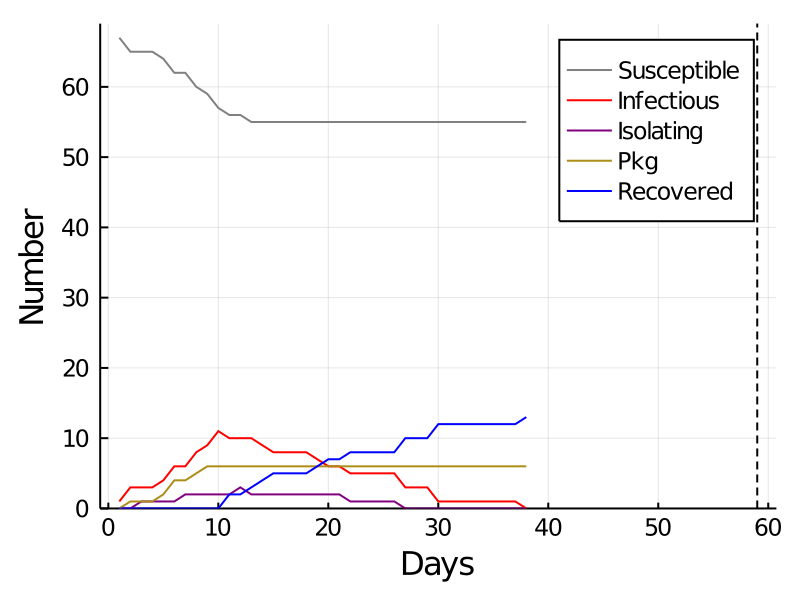

In [58]:
print(length(results["NetworkInfs"]))

Plots.plot([59,59],[0,70],color=:black,style=:dash,label=:none)
Plots.plot!(results["time"],transpose(sum(results["Susceptible"],dims=1)),label="Susceptible", color=:grey)
Plots.plot!(results["time"],transpose(sum(results["Infectious"],dims=1)),label="Infectious", color=:red)
Plots.plot!(results["time"],transpose(sum(results["Isolated"],dims=1)),label="Isolating", color=:purple)
# Plots.plot(results["time"],transpose(cumsum(sum(results["ExternalIntroductions"],dims=1),dims=2)),label="ExtIntros")
# Plots.plot!(results["time"],transposecumsum(sum(results["CustomerIntroductions"],dims=1),dims=2)),label="CustIntros")
Plots.plot!(results["time"],transpose(cumsum(sum(results["FomiteInfs"],dims=1),dims=2)),label="Pkg")
# Plots.plot!(results["time"],transpose(cumsum(sum(results["PairInfs"],dims=1),dims=2)),label="Pair")
R = results["Recovered"]
Rsum = sum(R,dims=1)
Plots.plot!(results["time"],transpose(Rsum),label="Recovered", color=:blue,
            legend=:topright,ylim=(0,69),xlabel="Days",ylabel="Number",size=(400,300),dpi=200)

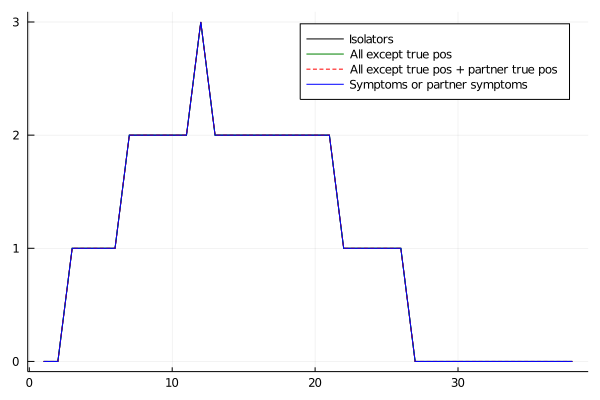

In [59]:
#Plots.plot(results["time"],transpose(sum(results["Infectious"],dims=1)),label="Infectious")
IS = results["Isolated"] 
IST1 = results["IsolatedDueToTestSymp"] + results["IsolatedDueToTestAsymp"]
IST2 = results["IsolatedDueToPartnerTruePos"]
ISF1 = results["IsolatedDueToFalsePos"]
ISF2 = results["IsolatedDueToPartnerFalsePos"]
ISS = IS - IST1 - IST2 - ISF1 - ISF2
Plots.plot(results["time"],transpose(sum(IS,dims=1)),label="Isolators", c = :black)
Plots.plot!(results["time"],transpose(sum(IS - IST1,dims=1)),label="All except true pos", c = :green)
Plots.plot!(results["time"],transpose(sum(IS - IST1 - IST2,dims=1)),label="All except true pos + partner true pos", c = :red, s=:dash)
Plots.plot!(results["time"],transpose(sum(IS - IST1 - IST2 - ISF1 - ISF2,dims=1)),label="Symptoms or partner symptoms", c = :blue)



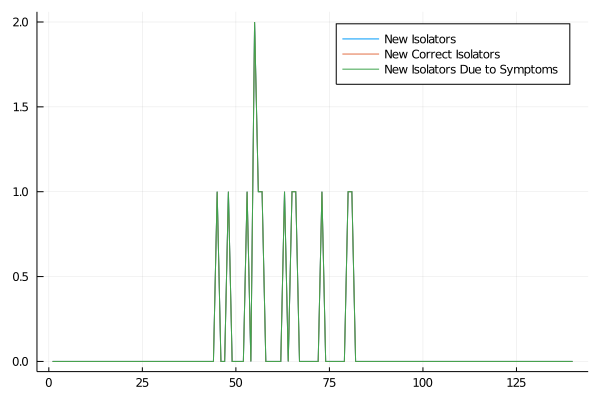

In [62]:
#Plots.plot(results["time"],transpose(sum(results["Infectious"],dims=1)),label="Infectious")
IS = results["NewIsolators"] 
Plots.plot(results["time"],transpose(sum(IS,dims=1)),label="New Isolators")
IS1 = IS .- results["NewFalseIsolators"]
Plots.plot!(results["time"],transpose(sum(IS1,dims=1)),label="New Correct Isolators")
IS2 = IS1 .- results["NewTestSympIsolators"] .- results["NewTestAsympIsolators"]
Plots.plot!(results["time"],transpose(sum(IS2,dims=1)),label="New Isolators Due to Symptoms")
#Plots.plot!(results["time"],transpose(sum(results["IsolatedDueToFalsePos"],dims=1)),label="Test Isolation FalsePos")
#Plots.plot!(results["time"],100*results["Incidence"])

In [520]:
print(sum(results["NewIsolators"] .- results["NewFalseIsolators"])/sum(results["Recovered"],dims=1)[end])

0.6060606060606061

In [17]:
Plots.plot(results["time"], results["CustomersInfectedByDrivers"])
#Plots.plot!(results["time"], results["PackagesInfectiousOnDelivery"])
Plots.plot!(results["time"], results["CustomersInfectedByPkgs"])
print(sum(results["CustomersInfectedByDrivers"]), ' ', sum(results["CustomersInfectedByPkgs"]))

7 4

In [69]:
n = sum(results["NetworkInfs"],dims=2)
c = sum(results["ContactInfs"],dims=2)
r = sum(results["RoomInfs"],dims=2)
e = sum(results["ExternalIntroductions"],dims=2)
ci = sum(results["CustomerIntroductions"],dims=2)
p = sum(results["PairInfs"],dims=2)
print(n+p)
print(results["Recovered"][:,end])

[14; 0; 1][24, 3, 4]

In [ ]:
#sc edits

In [3]:
rel_demand = [0.94905289, 1.12035227, 1.13224753, 1.11989019, 1.18869848, 0.96182216, 0.52793647]
print(rel_demand/max(rel_demand...))

[0.7983966548018132, 0.9425033251493683, 0.9525102867129096, 0.9421145974713453, 1.0, 0.809138882721546, 0.444129843591623]

In [27]:
results

Dict{Any,Any} with 33 entries:
  "Isolated"                     => [0 0 … 2 2; 0 0 … 0 0; 0 0 … 0 0]
  "NewTestSympIsolators"         => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "NewPartnerTruePosIsolators"   => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "IsolatedDueToPartnerTruePos"  => [0 0 … 1 1; 0 0 … 0 0; 0 0 … 0 0]
  "PairInfs"                     => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "NewIsolators"                 => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "CustomersInfectedByDrivers"   => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, …
  "IsolatedDueToFalsePos"        => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "IsolatedDueToSymptoms"        => [0 0 … 48 48; 0 0 … 30 30; 0 0 … 15 15]
  "Asymptomatic"                 => [0 0 … 3 3; 0 0 … 0 0; 0 0 … 0 0]
  "Susceptible"                  => [50 50 … 27 27; 30 30 … 27 27; 15 15 … 13 1…
  "FomiteInfs"                   => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "time"                         => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  131, 132…
  "ContactInfs"     

Defined Plot attributes are:
background_color, background_color_outside, display_type, dpi, extra_kwargs, extra_plot_kwargs, fontfamily, foreground_color, html_output_format, inset_subplots, layout, link, overwrite_figure, plot_title, plot_title_location, plot_titlefontcolor, plot_titlefontfamily, plot_titlefonthalign, plot_titlefontrotation, plot_titlefontsize, plot_titlefontvalign, pos, show, size, tex_output_standalone, thickness_scaling, warn_on_unsupported, window_title


89.00549056999311